<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw2/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement various autoencoder models and run them on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code. It may take longer to run since we are using larger datasets.

In [ ]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git
# This link may break due to google changing how files are linked. You can manually download from https://drive.google.com/drive/folders/1BOLGo3CFDa_qJMLRgtTZ6zrAWezk9oJu?usp=sharing 
!curl "https://drive.usercontent.google.com/download?id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF&confirm=xxx" -o hw2_data.zip
!unzip -qq hw2_data.zip -d deepul/homeworks/hw2/data
!pip install ./deepul

In [2]:
from deepul.hw2_helper import *

# Question 1: VAEs on 2D Data [20pts]
In this question, you will train a simple VAE on 2D data, and look at situations in which latents are being used or not being used (i.e. when posterior collapse occurs)

## Part (a) Data from a Full Covariance Gaussian [10 pts]
In this part, we train a VAE on data generated from a Gaussian with a full covariance matrix. Execute the cell below to visualize the datasets.

Dataset 1


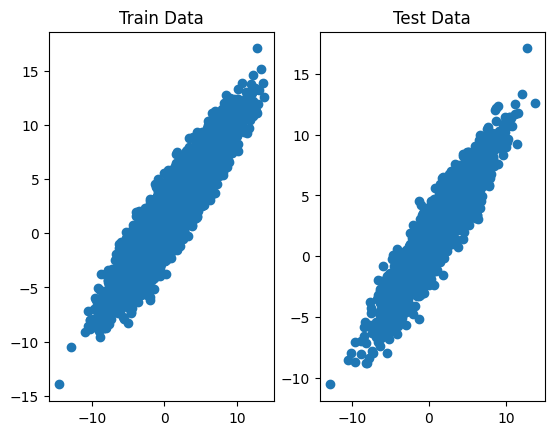

Dataset 2


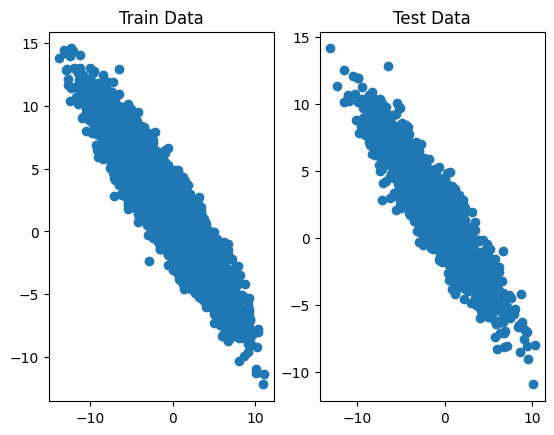

In [3]:
visualize_q1_data('a', 1)
visualize_q1_data('a', 2)

Consruct and train a VAE with the following characteristics
*   2D latent variables $z$ with a standard normal prior, $p(z) = N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), \Sigma_\phi(z))$, where $\mu_\phi(z)$ is the mean vector, and $\Sigma_\phi(z)$ is a diagonal covariance matrix

**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss $E_xE_{z\sim q(z|x)}[-p(x|z)]$, and KL term $E_x[D_{KL}(q(z|x)||p(z))]$ of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. Samples of your trained VAE with ($z\sim p(z), x\sim N(x;\mu_\phi(z),\Sigma_\phi(z))$) and without ($z\sim p(z), x = \mu_\phi(z)$) decoder noise




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import tqdm

class Encoder(nn.Module):
  def __init__(self, input_dim=2, hidden_dim=64, latent_dim=2):
    super().__init__()
    self.fc = nn.Sequential(
      nn.Linear(input_dim, hidden_dim),
      nn.ReLU(),
      nn.Linear(hidden_dim, hidden_dim),
      nn.ReLU()
    )
    self.fc_mu = nn.Linear(hidden_dim, latent_dim)
    self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

  def forward(self, x):
    h = self.fc(x)
    mu = self.fc_mu(h)
    logvar = self.fc_logvar(h)
    return mu, logvar
  
class Decoder(nn.Module):
  def __init__(self, latent_dim=2, hidden_dim=64, output_dim=2):
    super().__init__()
    self.fc = nn.Sequential(
      nn.Linear(latent_dim, hidden_dim),
      nn.ReLU(),
      nn.Linear(hidden_dim, hidden_dim),
      nn.ReLU()
    )
    self.fc_mu = nn.Linear(hidden_dim, output_dim)
    self.fc_logvar = nn.Linear(hidden_dim, output_dim)

  def forward(self, z):
    h = self.fc(z)
    mu = self.fc_mu(h)
    logvar = self.fc_logvar(h)
    return mu, logvar
  
def compute_loss(x, x_mu, x_logvar, z_mu, z_logvar):
  recon_loss = 0.5 * torch.sum(torch.exp(-x_logvar) * (x - x_mu) ** 2 + x_logvar, dim=1)
  kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mu ** 2 - torch.exp(z_logvar), dim=1)
  return recon_loss + kl_loss, recon_loss, kl_loss

def q1(train_data, test_data, part, dset_id):
  """
  train_data: An (n_train, 2) numpy array of floats
  test_data: An (n_test, 2) numpy array of floats

  (You probably won't need to use the two inputs below, but they are there
    if you want to use them)
  part: An identifying string ('a' or 'b') of which part is being run. Most likely
        used to set different hyperparameters for different datasets
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
              used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
    and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
  - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
    and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
  - a numpy array of size (1000, 2) of 1000 samples WITH decoder noise, i.e. sample z ~ p(z), x ~ p(x|z)
  - a numpy array of size (1000, 2) of 1000 samples WITHOUT decoder noise, i.e. sample z ~ p(z), x = mu(z)
  """

  """ YOUR CODE HERE """
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  train_data = torch.tensor(train_data, dtype=torch.float32, device=device)
  test_data = torch.tensor(test_data, dtype=torch.float32, device=device)

  encoder = Encoder().to(device)
  decoder = Decoder().to(device)
  optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)
  num_epochs = 60
  batch_size = 128

  n_train = train_data.shape[0]
  n_test = test_data.shape[0]

  train_losses = []
  test_losses = []
  for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    perm = torch.randperm(n_train)
    for i in tqdm.tqdm(range(0, n_train, batch_size), desc=f"Epoch {epoch}/{num_epochs}"):
      x = train_data[perm[i:i + batch_size]]
      z_mu, z_logvar = encoder(x)
      std = torch.exp(0.5 * z_logvar)
      eps = torch.randn_like(std)
      z = z_mu + eps * std
      x_mu, x_logvar = decoder(z)
      loss, recon_loss, kl_loss = compute_loss(x, x_mu, x_logvar, z_mu, z_logvar)
      optimizer.zero_grad()
      loss.mean().backward()
      optimizer.step()
      train_losses.append([loss.mean().item(), recon_loss.mean().item(), kl_loss.mean().item()])
    
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
      z_mu, z_logvar = encoder(test_data)
      std = torch.exp(0.5 * z_logvar)
      eps = torch.randn_like(std)
      z = z_mu + eps * std
      x_mu, x_logvar = decoder(z)
      loss, recon_loss, kl_loss = compute_loss(test_data, x_mu, x_logvar, z_mu, z_logvar)
      print(f"Test Loss: {loss.mean().item():.4f}, Recon Loss: {recon_loss.mean().item():.4f}, KL Loss: {kl_loss.mean().item():.4f}")
      test_losses.append([loss.mean().item(), recon_loss.mean().item(), kl_loss.mean().item()])

  encoder.eval()
  decoder.eval()
  with torch.no_grad():
    z_samples = torch.randn(1000, 2).to(device)
    x_mu, x_logvar = decoder(z_samples)
    eps = torch.randn_like(x_mu)
    samples_with_noise = x_mu + eps * torch.exp(0.5 * x_logvar)
    samples_without_noise = x_mu

  return np.array(train_losses), np.array(test_losses), samples_with_noise.cpu().numpy(), samples_without_noise.cpu().numpy()

### Results
Once you've finished `q1_a`, execute the cells below to visualize and save your results.

Epoch 0/60:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0/60: 100%|██████████| 79/79 [00:00<00:00, 471.25it/s]


Test Loss: 3.6071, Recon Loss: 3.4008, KL Loss: 0.2062


Epoch 1/60: 100%|██████████| 79/79 [00:00<00:00, 476.71it/s]


Test Loss: 3.5114, Recon Loss: 3.3154, KL Loss: 0.1960


Epoch 2/60: 100%|██████████| 79/79 [00:00<00:00, 475.83it/s]


Test Loss: 3.4980, Recon Loss: 3.3016, KL Loss: 0.1964


Epoch 3/60: 100%|██████████| 79/79 [00:00<00:00, 477.98it/s]


Test Loss: 3.4902, Recon Loss: 3.2720, KL Loss: 0.2183


Epoch 4/60: 100%|██████████| 79/79 [00:00<00:00, 476.80it/s]


Test Loss: 3.4884, Recon Loss: 3.2345, KL Loss: 0.2538


Epoch 5/60: 100%|██████████| 79/79 [00:00<00:00, 477.69it/s]


Test Loss: 3.4744, Recon Loss: 3.2420, KL Loss: 0.2324


Epoch 6/60: 100%|██████████| 79/79 [00:00<00:00, 477.89it/s]


Test Loss: 3.4515, Recon Loss: 3.1859, KL Loss: 0.2656


Epoch 7/60: 100%|██████████| 79/79 [00:00<00:00, 476.77it/s]


Test Loss: 3.4270, Recon Loss: 3.1152, KL Loss: 0.3118


Epoch 8/60: 100%|██████████| 79/79 [00:00<00:00, 475.83it/s]


Test Loss: 3.1960, Recon Loss: 2.2384, KL Loss: 0.9575


Epoch 9/60: 100%|██████████| 79/79 [00:00<00:00, 477.21it/s]


Test Loss: 3.1880, Recon Loss: 1.9245, KL Loss: 1.2635


Epoch 10/60: 100%|██████████| 79/79 [00:00<00:00, 449.68it/s]


Test Loss: 2.9209, Recon Loss: 1.3765, KL Loss: 1.5444


Epoch 11/60: 100%|██████████| 79/79 [00:00<00:00, 476.48it/s]


Test Loss: 2.8998, Recon Loss: 1.3623, KL Loss: 1.5375


Epoch 12/60: 100%|██████████| 79/79 [00:00<00:00, 474.49it/s]


Test Loss: 2.8791, Recon Loss: 1.4497, KL Loss: 1.4294


Epoch 13/60: 100%|██████████| 79/79 [00:00<00:00, 478.88it/s]


Test Loss: 2.8991, Recon Loss: 1.3869, KL Loss: 1.5122


Epoch 14/60: 100%|██████████| 79/79 [00:00<00:00, 484.61it/s]


Test Loss: 2.8193, Recon Loss: 1.2321, KL Loss: 1.5872


Epoch 15/60: 100%|██████████| 79/79 [00:00<00:00, 487.24it/s]


Test Loss: 2.8686, Recon Loss: 1.3205, KL Loss: 1.5481


Epoch 16/60: 100%|██████████| 79/79 [00:00<00:00, 486.59it/s]


Test Loss: 2.8269, Recon Loss: 1.1384, KL Loss: 1.6885


Epoch 17/60: 100%|██████████| 79/79 [00:00<00:00, 487.31it/s]


Test Loss: 2.8003, Recon Loss: 1.1806, KL Loss: 1.6196


Epoch 18/60: 100%|██████████| 79/79 [00:00<00:00, 487.06it/s]


Test Loss: 2.8312, Recon Loss: 1.1761, KL Loss: 1.6551


Epoch 19/60: 100%|██████████| 79/79 [00:00<00:00, 486.91it/s]


Test Loss: 2.7621, Recon Loss: 1.1691, KL Loss: 1.5930


Epoch 20/60: 100%|██████████| 79/79 [00:00<00:00, 487.38it/s]


Test Loss: 2.6929, Recon Loss: 1.1116, KL Loss: 1.5813


Epoch 21/60: 100%|██████████| 79/79 [00:00<00:00, 488.32it/s]


Test Loss: 2.7160, Recon Loss: 1.2022, KL Loss: 1.5138


Epoch 22/60: 100%|██████████| 79/79 [00:00<00:00, 487.46it/s]


Test Loss: 2.6356, Recon Loss: 1.1345, KL Loss: 1.5011


Epoch 23/60: 100%|██████████| 79/79 [00:00<00:00, 487.48it/s]


Test Loss: 2.6094, Recon Loss: 0.9883, KL Loss: 1.6211


Epoch 24/60: 100%|██████████| 79/79 [00:00<00:00, 486.87it/s]


Test Loss: 2.6059, Recon Loss: 0.9693, KL Loss: 1.6366


Epoch 25/60: 100%|██████████| 79/79 [00:00<00:00, 486.31it/s]


Test Loss: 2.6012, Recon Loss: 0.9756, KL Loss: 1.6256


Epoch 26/60: 100%|██████████| 79/79 [00:00<00:00, 486.76it/s]


Test Loss: 2.5978, Recon Loss: 1.0011, KL Loss: 1.5967


Epoch 27/60: 100%|██████████| 79/79 [00:00<00:00, 487.95it/s]


Test Loss: 2.5953, Recon Loss: 1.0088, KL Loss: 1.5866


Epoch 28/60: 100%|██████████| 79/79 [00:00<00:00, 488.17it/s]


Test Loss: 2.6872, Recon Loss: 1.0197, KL Loss: 1.6675


Epoch 29/60: 100%|██████████| 79/79 [00:00<00:00, 487.94it/s]


Test Loss: 2.6179, Recon Loss: 1.0250, KL Loss: 1.5929


Epoch 30/60: 100%|██████████| 79/79 [00:00<00:00, 487.70it/s]


Test Loss: 2.5883, Recon Loss: 1.0075, KL Loss: 1.5808


Epoch 31/60: 100%|██████████| 79/79 [00:00<00:00, 488.85it/s]


Test Loss: 2.5903, Recon Loss: 0.9794, KL Loss: 1.6110


Epoch 32/60: 100%|██████████| 79/79 [00:00<00:00, 490.68it/s]


Test Loss: 2.6018, Recon Loss: 1.0374, KL Loss: 1.5644


Epoch 33/60: 100%|██████████| 79/79 [00:00<00:00, 493.89it/s]


Test Loss: 2.6228, Recon Loss: 1.0799, KL Loss: 1.5430


Epoch 34/60: 100%|██████████| 79/79 [00:00<00:00, 494.41it/s]


Test Loss: 2.6006, Recon Loss: 1.0453, KL Loss: 1.5553


Epoch 35/60: 100%|██████████| 79/79 [00:00<00:00, 494.46it/s]


Test Loss: 2.5790, Recon Loss: 1.0439, KL Loss: 1.5351


Epoch 36/60: 100%|██████████| 79/79 [00:00<00:00, 496.02it/s]


Test Loss: 2.6028, Recon Loss: 1.0178, KL Loss: 1.5850


Epoch 37/60: 100%|██████████| 79/79 [00:00<00:00, 495.15it/s]


Test Loss: 2.5822, Recon Loss: 1.0039, KL Loss: 1.5783


Epoch 38/60: 100%|██████████| 79/79 [00:00<00:00, 496.47it/s]


Test Loss: 2.5941, Recon Loss: 1.0392, KL Loss: 1.5549


Epoch 39/60: 100%|██████████| 79/79 [00:00<00:00, 496.93it/s]


Test Loss: 2.6183, Recon Loss: 1.0303, KL Loss: 1.5880


Epoch 40/60: 100%|██████████| 79/79 [00:00<00:00, 469.51it/s]


Test Loss: 2.6066, Recon Loss: 1.0028, KL Loss: 1.6037


Epoch 41/60: 100%|██████████| 79/79 [00:00<00:00, 469.34it/s]


Test Loss: 2.5970, Recon Loss: 0.9484, KL Loss: 1.6486


Epoch 42/60: 100%|██████████| 79/79 [00:00<00:00, 481.32it/s]


Test Loss: 2.5797, Recon Loss: 0.9687, KL Loss: 1.6110


Epoch 43/60: 100%|██████████| 79/79 [00:00<00:00, 483.43it/s]


Test Loss: 2.6091, Recon Loss: 1.0287, KL Loss: 1.5804


Epoch 44/60: 100%|██████████| 79/79 [00:00<00:00, 482.65it/s]


Test Loss: 2.6131, Recon Loss: 0.9905, KL Loss: 1.6227


Epoch 45/60: 100%|██████████| 79/79 [00:00<00:00, 481.11it/s]


Test Loss: 2.5768, Recon Loss: 0.9339, KL Loss: 1.6429


Epoch 46/60: 100%|██████████| 79/79 [00:00<00:00, 480.96it/s]


Test Loss: 2.5874, Recon Loss: 0.9823, KL Loss: 1.6051


Epoch 47/60: 100%|██████████| 79/79 [00:00<00:00, 478.79it/s]


Test Loss: 2.5887, Recon Loss: 1.0048, KL Loss: 1.5839


Epoch 48/60: 100%|██████████| 79/79 [00:00<00:00, 483.06it/s]


Test Loss: 2.6331, Recon Loss: 0.9998, KL Loss: 1.6333


Epoch 49/60: 100%|██████████| 79/79 [00:00<00:00, 485.64it/s]


Test Loss: 2.6141, Recon Loss: 1.0304, KL Loss: 1.5837


Epoch 50/60: 100%|██████████| 79/79 [00:00<00:00, 489.36it/s]


Test Loss: 2.6010, Recon Loss: 1.0224, KL Loss: 1.5786


Epoch 51/60: 100%|██████████| 79/79 [00:00<00:00, 489.96it/s]


Test Loss: 2.5787, Recon Loss: 0.9651, KL Loss: 1.6136


Epoch 52/60: 100%|██████████| 79/79 [00:00<00:00, 488.06it/s]


Test Loss: 2.6339, Recon Loss: 1.0874, KL Loss: 1.5465


Epoch 53/60: 100%|██████████| 79/79 [00:00<00:00, 489.51it/s]


Test Loss: 2.6099, Recon Loss: 0.9742, KL Loss: 1.6357


Epoch 54/60: 100%|██████████| 79/79 [00:00<00:00, 490.14it/s]


Test Loss: 2.5733, Recon Loss: 0.9932, KL Loss: 1.5801


Epoch 55/60: 100%|██████████| 79/79 [00:00<00:00, 490.63it/s]


Test Loss: 2.6073, Recon Loss: 0.9853, KL Loss: 1.6220


Epoch 56/60: 100%|██████████| 79/79 [00:00<00:00, 490.10it/s]


Test Loss: 2.6109, Recon Loss: 0.9656, KL Loss: 1.6453


Epoch 57/60: 100%|██████████| 79/79 [00:00<00:00, 491.25it/s]


Test Loss: 2.5824, Recon Loss: 0.9909, KL Loss: 1.5915


Epoch 58/60: 100%|██████████| 79/79 [00:00<00:00, 490.98it/s]


Test Loss: 2.5584, Recon Loss: 0.9932, KL Loss: 1.5652


Epoch 59/60: 100%|██████████| 79/79 [00:00<00:00, 492.03it/s]


Test Loss: 2.5981, Recon Loss: 0.9876, KL Loss: 1.6105
Final -ELBO: 2.5981, Recon Loss: 0.9876, KL Loss: 1.6105


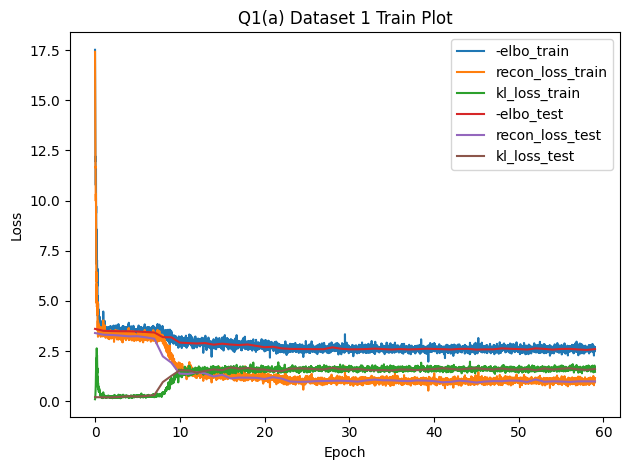

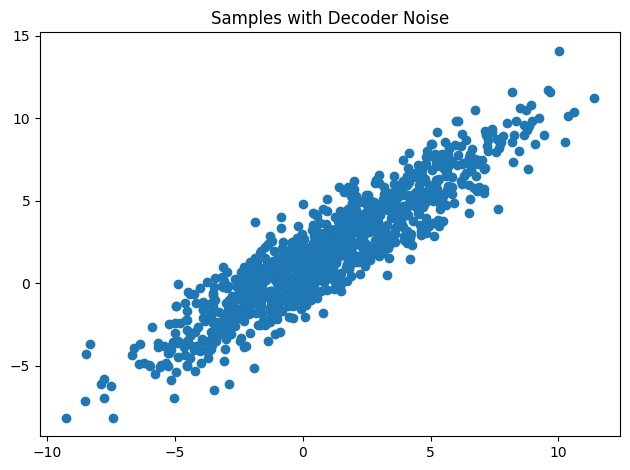

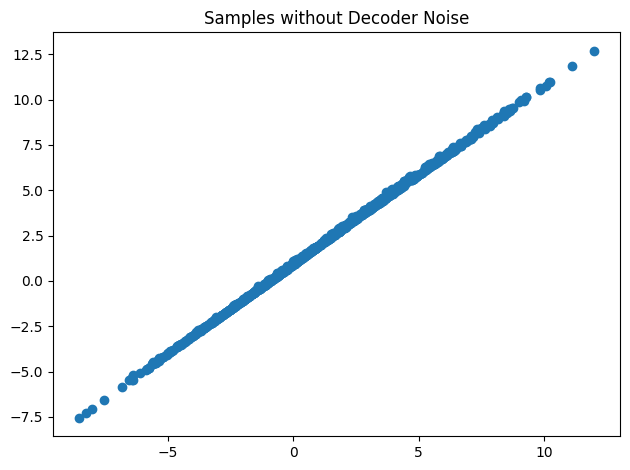

In [24]:
q1_save_results('a', 1, q1)

Epoch 0/60: 100%|██████████| 79/79 [00:00<00:00, 477.74it/s]


Test Loss: 3.6059, Recon Loss: 3.2495, KL Loss: 0.3564


Epoch 1/60: 100%|██████████| 79/79 [00:00<00:00, 482.81it/s]


Test Loss: 3.4010, Recon Loss: 2.9930, KL Loss: 0.4080


Epoch 2/60: 100%|██████████| 79/79 [00:00<00:00, 482.70it/s]


Test Loss: 3.0407, Recon Loss: 2.0923, KL Loss: 0.9485


Epoch 3/60: 100%|██████████| 79/79 [00:00<00:00, 460.37it/s]


Test Loss: 2.6651, Recon Loss: 1.1670, KL Loss: 1.4981


Epoch 4/60: 100%|██████████| 79/79 [00:00<00:00, 482.47it/s]


Test Loss: 2.6472, Recon Loss: 1.2305, KL Loss: 1.4167


Epoch 5/60: 100%|██████████| 79/79 [00:00<00:00, 488.46it/s]


Test Loss: 2.5793, Recon Loss: 0.9922, KL Loss: 1.5871


Epoch 6/60: 100%|██████████| 79/79 [00:00<00:00, 490.91it/s]


Test Loss: 2.6375, Recon Loss: 1.1369, KL Loss: 1.5006


Epoch 7/60: 100%|██████████| 79/79 [00:00<00:00, 490.84it/s]


Test Loss: 2.6019, Recon Loss: 1.0887, KL Loss: 1.5133


Epoch 8/60: 100%|██████████| 79/79 [00:00<00:00, 490.39it/s]


Test Loss: 2.6209, Recon Loss: 1.0354, KL Loss: 1.5855


Epoch 9/60: 100%|██████████| 79/79 [00:00<00:00, 491.27it/s]


Test Loss: 2.6028, Recon Loss: 1.0614, KL Loss: 1.5413


Epoch 10/60: 100%|██████████| 79/79 [00:00<00:00, 491.61it/s]


Test Loss: 2.5961, Recon Loss: 1.0229, KL Loss: 1.5731


Epoch 11/60: 100%|██████████| 79/79 [00:00<00:00, 491.27it/s]


Test Loss: 2.6180, Recon Loss: 1.0535, KL Loss: 1.5645


Epoch 12/60: 100%|██████████| 79/79 [00:00<00:00, 489.72it/s]


Test Loss: 2.6145, Recon Loss: 1.0808, KL Loss: 1.5336


Epoch 13/60: 100%|██████████| 79/79 [00:00<00:00, 492.67it/s]


Test Loss: 2.6091, Recon Loss: 1.0708, KL Loss: 1.5383


Epoch 14/60: 100%|██████████| 79/79 [00:00<00:00, 491.23it/s]


Test Loss: 2.6361, Recon Loss: 0.9959, KL Loss: 1.6402


Epoch 15/60: 100%|██████████| 79/79 [00:00<00:00, 492.79it/s]


Test Loss: 2.6030, Recon Loss: 0.9934, KL Loss: 1.6095


Epoch 16/60: 100%|██████████| 79/79 [00:00<00:00, 492.26it/s]


Test Loss: 2.5969, Recon Loss: 1.0228, KL Loss: 1.5742


Epoch 17/60: 100%|██████████| 79/79 [00:00<00:00, 489.61it/s]


Test Loss: 2.5931, Recon Loss: 0.9735, KL Loss: 1.6196


Epoch 18/60: 100%|██████████| 79/79 [00:00<00:00, 492.78it/s]


Test Loss: 2.6389, Recon Loss: 1.0622, KL Loss: 1.5767


Epoch 19/60: 100%|██████████| 79/79 [00:00<00:00, 492.11it/s]


Test Loss: 2.5482, Recon Loss: 0.9875, KL Loss: 1.5607


Epoch 20/60: 100%|██████████| 79/79 [00:00<00:00, 492.80it/s]


Test Loss: 2.5682, Recon Loss: 1.0022, KL Loss: 1.5659


Epoch 21/60: 100%|██████████| 79/79 [00:00<00:00, 492.63it/s]


Test Loss: 2.5766, Recon Loss: 1.0020, KL Loss: 1.5746


Epoch 22/60: 100%|██████████| 79/79 [00:00<00:00, 493.22it/s]


Test Loss: 2.6505, Recon Loss: 1.0209, KL Loss: 1.6297


Epoch 23/60: 100%|██████████| 79/79 [00:00<00:00, 491.49it/s]


Test Loss: 2.5743, Recon Loss: 0.9702, KL Loss: 1.6041


Epoch 24/60: 100%|██████████| 79/79 [00:00<00:00, 492.52it/s]


Test Loss: 2.6228, Recon Loss: 1.0274, KL Loss: 1.5954


Epoch 25/60: 100%|██████████| 79/79 [00:00<00:00, 492.53it/s]


Test Loss: 2.5878, Recon Loss: 1.0417, KL Loss: 1.5460


Epoch 26/60: 100%|██████████| 79/79 [00:00<00:00, 492.42it/s]


Test Loss: 2.6037, Recon Loss: 1.0295, KL Loss: 1.5742


Epoch 27/60: 100%|██████████| 79/79 [00:00<00:00, 492.85it/s]


Test Loss: 2.6049, Recon Loss: 0.9677, KL Loss: 1.6373


Epoch 28/60: 100%|██████████| 79/79 [00:00<00:00, 492.93it/s]


Test Loss: 2.6204, Recon Loss: 1.0839, KL Loss: 1.5365


Epoch 29/60: 100%|██████████| 79/79 [00:00<00:00, 491.96it/s]


Test Loss: 2.5604, Recon Loss: 0.9821, KL Loss: 1.5783


Epoch 30/60: 100%|██████████| 79/79 [00:00<00:00, 492.94it/s]


Test Loss: 2.6210, Recon Loss: 0.9993, KL Loss: 1.6217


Epoch 31/60: 100%|██████████| 79/79 [00:00<00:00, 492.16it/s]


Test Loss: 2.6312, Recon Loss: 1.0282, KL Loss: 1.6030


Epoch 32/60: 100%|██████████| 79/79 [00:00<00:00, 492.31it/s]


Test Loss: 2.7046, Recon Loss: 1.1138, KL Loss: 1.5908


Epoch 33/60: 100%|██████████| 79/79 [00:00<00:00, 493.45it/s]


Test Loss: 2.6063, Recon Loss: 1.0244, KL Loss: 1.5819


Epoch 34/60: 100%|██████████| 79/79 [00:00<00:00, 466.26it/s]


Test Loss: 2.5671, Recon Loss: 0.9510, KL Loss: 1.6162


Epoch 35/60: 100%|██████████| 79/79 [00:00<00:00, 484.91it/s]


Test Loss: 2.5725, Recon Loss: 0.9684, KL Loss: 1.6042


Epoch 36/60: 100%|██████████| 79/79 [00:00<00:00, 487.12it/s]


Test Loss: 2.6071, Recon Loss: 1.0205, KL Loss: 1.5865


Epoch 37/60: 100%|██████████| 79/79 [00:00<00:00, 484.22it/s]


Test Loss: 2.5878, Recon Loss: 1.0301, KL Loss: 1.5577


Epoch 38/60: 100%|██████████| 79/79 [00:00<00:00, 486.09it/s]


Test Loss: 2.6116, Recon Loss: 1.0497, KL Loss: 1.5619


Epoch 39/60: 100%|██████████| 79/79 [00:00<00:00, 486.03it/s]


Test Loss: 2.6274, Recon Loss: 0.9887, KL Loss: 1.6387


Epoch 40/60: 100%|██████████| 79/79 [00:00<00:00, 486.91it/s]


Test Loss: 2.6056, Recon Loss: 1.0298, KL Loss: 1.5759


Epoch 41/60: 100%|██████████| 79/79 [00:00<00:00, 487.22it/s]


Test Loss: 2.6040, Recon Loss: 0.9911, KL Loss: 1.6129


Epoch 42/60: 100%|██████████| 79/79 [00:00<00:00, 487.43it/s]


Test Loss: 2.5791, Recon Loss: 0.9937, KL Loss: 1.5854


Epoch 43/60: 100%|██████████| 79/79 [00:00<00:00, 486.72it/s]


Test Loss: 2.5956, Recon Loss: 1.0620, KL Loss: 1.5337


Epoch 44/60: 100%|██████████| 79/79 [00:00<00:00, 489.93it/s]


Test Loss: 2.6029, Recon Loss: 1.0103, KL Loss: 1.5926


Epoch 45/60: 100%|██████████| 79/79 [00:00<00:00, 491.76it/s]


Test Loss: 2.6192, Recon Loss: 1.0368, KL Loss: 1.5823


Epoch 46/60: 100%|██████████| 79/79 [00:00<00:00, 489.44it/s]


Test Loss: 2.5961, Recon Loss: 1.0290, KL Loss: 1.5671


Epoch 47/60: 100%|██████████| 79/79 [00:00<00:00, 489.56it/s]


Test Loss: 2.6152, Recon Loss: 1.0393, KL Loss: 1.5760


Epoch 48/60: 100%|██████████| 79/79 [00:00<00:00, 489.84it/s]


Test Loss: 2.5933, Recon Loss: 1.0570, KL Loss: 1.5363


Epoch 49/60: 100%|██████████| 79/79 [00:00<00:00, 489.46it/s]


Test Loss: 2.6140, Recon Loss: 1.0569, KL Loss: 1.5571


Epoch 50/60: 100%|██████████| 79/79 [00:00<00:00, 489.48it/s]


Test Loss: 2.5810, Recon Loss: 0.9714, KL Loss: 1.6096


Epoch 51/60: 100%|██████████| 79/79 [00:00<00:00, 489.92it/s]


Test Loss: 2.5792, Recon Loss: 1.0212, KL Loss: 1.5581


Epoch 52/60: 100%|██████████| 79/79 [00:00<00:00, 490.52it/s]


Test Loss: 2.5818, Recon Loss: 0.9892, KL Loss: 1.5926


Epoch 53/60: 100%|██████████| 79/79 [00:00<00:00, 489.75it/s]


Test Loss: 2.5907, Recon Loss: 0.9937, KL Loss: 1.5970


Epoch 54/60: 100%|██████████| 79/79 [00:00<00:00, 490.69it/s]


Test Loss: 2.6072, Recon Loss: 1.0299, KL Loss: 1.5773


Epoch 55/60: 100%|██████████| 79/79 [00:00<00:00, 490.55it/s]


Test Loss: 2.5887, Recon Loss: 0.9758, KL Loss: 1.6129


Epoch 56/60: 100%|██████████| 79/79 [00:00<00:00, 489.26it/s]


Test Loss: 2.6053, Recon Loss: 0.9530, KL Loss: 1.6523


Epoch 57/60: 100%|██████████| 79/79 [00:00<00:00, 492.22it/s]


Test Loss: 2.6112, Recon Loss: 0.9909, KL Loss: 1.6203


Epoch 58/60: 100%|██████████| 79/79 [00:00<00:00, 489.14it/s]


Test Loss: 2.5793, Recon Loss: 0.9394, KL Loss: 1.6399


Epoch 59/60: 100%|██████████| 79/79 [00:00<00:00, 490.11it/s]


Test Loss: 2.6114, Recon Loss: 1.0277, KL Loss: 1.5837
Final -ELBO: 2.6114, Recon Loss: 1.0277, KL Loss: 1.5837


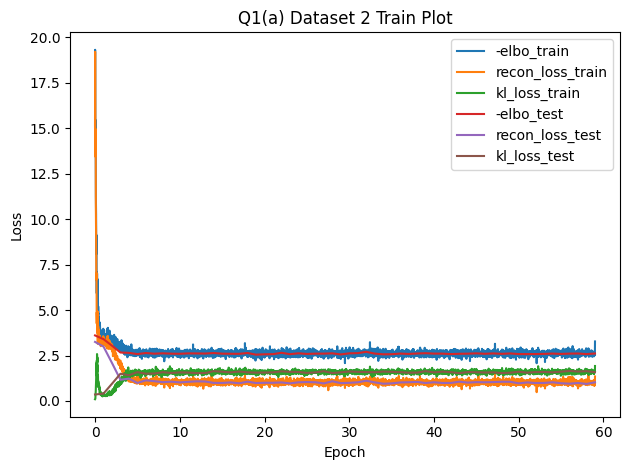

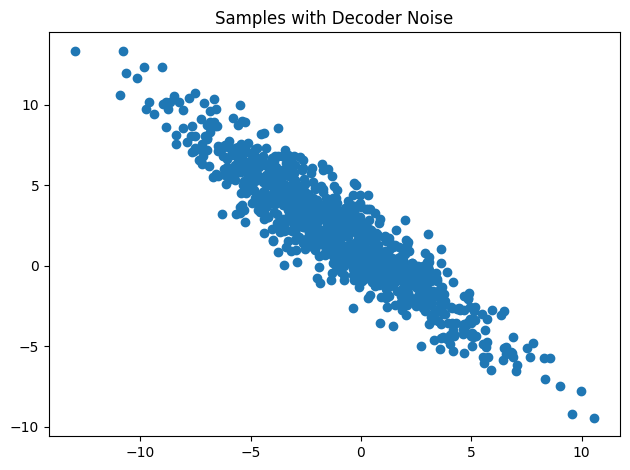

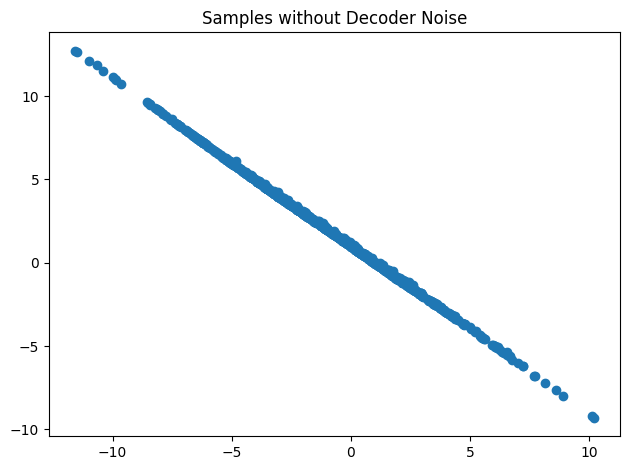

In [25]:
q1_save_results('a', 2, q1)

## Part (b) Data from a Diagonal Gaussian [10pts]
In this part, we use your code from the previous part to train a VAE on data generated from a diagonal gaussian. Execute the cell below to visualize the datasets (note that they may look the same, but notice the axes)

Dataset 1


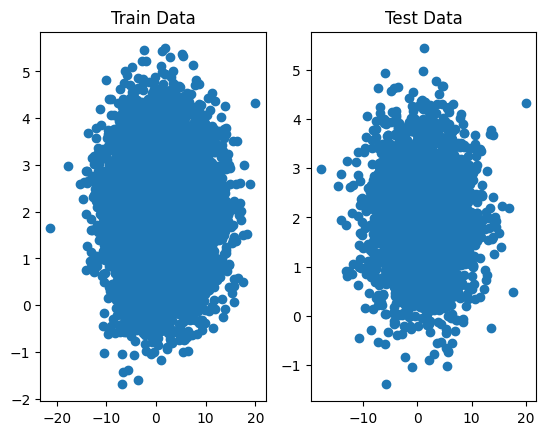

Dataset 2


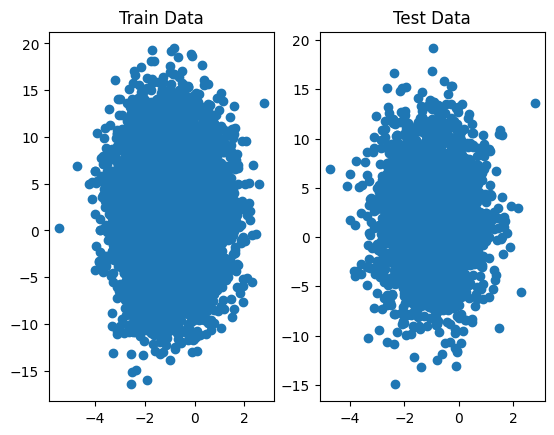

In [26]:
visualize_q1_data('b', 1)
visualize_q1_data('b', 2)

### Results
Execute the cells below to visualize and save your results.

Epoch 0/60: 100%|██████████| 79/79 [00:00<00:00, 479.34it/s]


Test Loss: 2.8433, Recon Loss: 2.7584, KL Loss: 0.0848


Epoch 1/60: 100%|██████████| 79/79 [00:00<00:00, 491.34it/s]


Test Loss: 2.6549, Recon Loss: 2.5822, KL Loss: 0.0726


Epoch 2/60: 100%|██████████| 79/79 [00:00<00:00, 492.69it/s]


Test Loss: 2.6288, Recon Loss: 2.5676, KL Loss: 0.0612


Epoch 3/60: 100%|██████████| 79/79 [00:00<00:00, 493.80it/s]


Test Loss: 2.6059, Recon Loss: 2.5697, KL Loss: 0.0361


Epoch 4/60: 100%|██████████| 79/79 [00:00<00:00, 493.63it/s]


Test Loss: 2.5934, Recon Loss: 2.5693, KL Loss: 0.0241


Epoch 5/60: 100%|██████████| 79/79 [00:00<00:00, 491.27it/s]


Test Loss: 2.5901, Recon Loss: 2.5754, KL Loss: 0.0147


Epoch 6/60: 100%|██████████| 79/79 [00:00<00:00, 492.51it/s]


Test Loss: 2.5848, Recon Loss: 2.5730, KL Loss: 0.0118


Epoch 7/60: 100%|██████████| 79/79 [00:00<00:00, 493.50it/s]


Test Loss: 2.5929, Recon Loss: 2.5825, KL Loss: 0.0104


Epoch 8/60: 100%|██████████| 79/79 [00:00<00:00, 492.68it/s]


Test Loss: 2.5888, Recon Loss: 2.5802, KL Loss: 0.0087


Epoch 9/60: 100%|██████████| 79/79 [00:00<00:00, 492.75it/s]


Test Loss: 2.5828, Recon Loss: 2.5747, KL Loss: 0.0081


Epoch 10/60: 100%|██████████| 79/79 [00:00<00:00, 493.04it/s]


Test Loss: 2.5821, Recon Loss: 2.5758, KL Loss: 0.0063


Epoch 11/60: 100%|██████████| 79/79 [00:00<00:00, 488.91it/s]


Test Loss: 2.5855, Recon Loss: 2.5797, KL Loss: 0.0057


Epoch 12/60: 100%|██████████| 79/79 [00:00<00:00, 491.72it/s]


Test Loss: 2.5866, Recon Loss: 2.5804, KL Loss: 0.0061


Epoch 13/60: 100%|██████████| 79/79 [00:00<00:00, 491.10it/s]


Test Loss: 2.5824, Recon Loss: 2.5783, KL Loss: 0.0041


Epoch 14/60: 100%|██████████| 79/79 [00:00<00:00, 489.96it/s]


Test Loss: 2.5827, Recon Loss: 2.5781, KL Loss: 0.0046


Epoch 15/60: 100%|██████████| 79/79 [00:00<00:00, 491.67it/s]


Test Loss: 2.5886, Recon Loss: 2.5844, KL Loss: 0.0042


Epoch 16/60: 100%|██████████| 79/79 [00:00<00:00, 491.62it/s]


Test Loss: 2.5845, Recon Loss: 2.5805, KL Loss: 0.0040


Epoch 17/60: 100%|██████████| 79/79 [00:00<00:00, 491.43it/s]


Test Loss: 2.5814, Recon Loss: 2.5792, KL Loss: 0.0023


Epoch 18/60: 100%|██████████| 79/79 [00:00<00:00, 490.40it/s]


Test Loss: 2.5818, Recon Loss: 2.5787, KL Loss: 0.0031


Epoch 19/60: 100%|██████████| 79/79 [00:00<00:00, 457.97it/s]


Test Loss: 2.5839, Recon Loss: 2.5794, KL Loss: 0.0045


Epoch 20/60: 100%|██████████| 79/79 [00:00<00:00, 488.81it/s]


Test Loss: 2.5823, Recon Loss: 2.5801, KL Loss: 0.0022


Epoch 21/60: 100%|██████████| 79/79 [00:00<00:00, 489.02it/s]


Test Loss: 2.5828, Recon Loss: 2.5771, KL Loss: 0.0057


Epoch 22/60: 100%|██████████| 79/79 [00:00<00:00, 492.41it/s]


Test Loss: 2.5838, Recon Loss: 2.5760, KL Loss: 0.0077


Epoch 23/60: 100%|██████████| 79/79 [00:00<00:00, 492.64it/s]


Test Loss: 2.5851, Recon Loss: 2.5760, KL Loss: 0.0091


Epoch 24/60: 100%|██████████| 79/79 [00:00<00:00, 492.78it/s]


Test Loss: 2.5890, Recon Loss: 2.5764, KL Loss: 0.0125


Epoch 25/60: 100%|██████████| 79/79 [00:00<00:00, 490.99it/s]


Test Loss: 2.5902, Recon Loss: 2.5784, KL Loss: 0.0118


Epoch 26/60: 100%|██████████| 79/79 [00:00<00:00, 491.94it/s]


Test Loss: 2.5925, Recon Loss: 2.5780, KL Loss: 0.0145


Epoch 27/60: 100%|██████████| 79/79 [00:00<00:00, 492.82it/s]


Test Loss: 2.5817, Recon Loss: 2.5721, KL Loss: 0.0097


Epoch 28/60: 100%|██████████| 79/79 [00:00<00:00, 493.82it/s]


Test Loss: 2.5866, Recon Loss: 2.5802, KL Loss: 0.0064


Epoch 29/60: 100%|██████████| 79/79 [00:00<00:00, 492.26it/s]


Test Loss: 2.5841, Recon Loss: 2.5788, KL Loss: 0.0053


Epoch 30/60: 100%|██████████| 79/79 [00:00<00:00, 492.65it/s]


Test Loss: 2.5827, Recon Loss: 2.5765, KL Loss: 0.0062


Epoch 31/60: 100%|██████████| 79/79 [00:00<00:00, 493.39it/s]


Test Loss: 2.5847, Recon Loss: 2.5781, KL Loss: 0.0066


Epoch 32/60: 100%|██████████| 79/79 [00:00<00:00, 493.59it/s]


Test Loss: 2.5827, Recon Loss: 2.5763, KL Loss: 0.0064


Epoch 33/60: 100%|██████████| 79/79 [00:00<00:00, 491.76it/s]


Test Loss: 2.5822, Recon Loss: 2.5683, KL Loss: 0.0140


Epoch 34/60: 100%|██████████| 79/79 [00:00<00:00, 489.56it/s]


Test Loss: 2.5857, Recon Loss: 2.5785, KL Loss: 0.0072


Epoch 35/60: 100%|██████████| 79/79 [00:00<00:00, 493.78it/s]


Test Loss: 2.5867, Recon Loss: 2.5788, KL Loss: 0.0080


Epoch 36/60: 100%|██████████| 79/79 [00:00<00:00, 493.40it/s]


Test Loss: 2.5864, Recon Loss: 2.5715, KL Loss: 0.0150


Epoch 37/60: 100%|██████████| 79/79 [00:00<00:00, 494.31it/s]


Test Loss: 2.5840, Recon Loss: 2.5798, KL Loss: 0.0042


Epoch 38/60: 100%|██████████| 79/79 [00:00<00:00, 494.32it/s]


Test Loss: 2.5843, Recon Loss: 2.5768, KL Loss: 0.0075


Epoch 39/60: 100%|██████████| 79/79 [00:00<00:00, 493.46it/s]


Test Loss: 2.5842, Recon Loss: 2.5756, KL Loss: 0.0087


Epoch 40/60: 100%|██████████| 79/79 [00:00<00:00, 492.79it/s]


Test Loss: 2.5800, Recon Loss: 2.5740, KL Loss: 0.0061


Epoch 41/60: 100%|██████████| 79/79 [00:00<00:00, 492.38it/s]


Test Loss: 2.5817, Recon Loss: 2.5725, KL Loss: 0.0092


Epoch 42/60: 100%|██████████| 79/79 [00:00<00:00, 492.12it/s]


Test Loss: 2.5869, Recon Loss: 2.5811, KL Loss: 0.0058


Epoch 43/60: 100%|██████████| 79/79 [00:00<00:00, 492.51it/s]


Test Loss: 2.5855, Recon Loss: 2.5745, KL Loss: 0.0110


Epoch 44/60: 100%|██████████| 79/79 [00:00<00:00, 493.14it/s]


Test Loss: 2.5840, Recon Loss: 2.5772, KL Loss: 0.0068


Epoch 45/60: 100%|██████████| 79/79 [00:00<00:00, 491.50it/s]


Test Loss: 2.5824, Recon Loss: 2.5737, KL Loss: 0.0087


Epoch 46/60: 100%|██████████| 79/79 [00:00<00:00, 490.30it/s]


Test Loss: 2.5793, Recon Loss: 2.5681, KL Loss: 0.0111


Epoch 47/60: 100%|██████████| 79/79 [00:00<00:00, 492.27it/s]


Test Loss: 2.5833, Recon Loss: 2.5771, KL Loss: 0.0062


Epoch 48/60: 100%|██████████| 79/79 [00:00<00:00, 494.54it/s]


Test Loss: 2.5864, Recon Loss: 2.5787, KL Loss: 0.0076


Epoch 49/60: 100%|██████████| 79/79 [00:00<00:00, 488.12it/s]


Test Loss: 2.5855, Recon Loss: 2.5743, KL Loss: 0.0112


Epoch 50/60: 100%|██████████| 79/79 [00:00<00:00, 483.06it/s]


Test Loss: 2.5802, Recon Loss: 2.5720, KL Loss: 0.0081


Epoch 51/60: 100%|██████████| 79/79 [00:00<00:00, 500.71it/s]


Test Loss: 2.5812, Recon Loss: 2.5733, KL Loss: 0.0079


Epoch 52/60: 100%|██████████| 79/79 [00:00<00:00, 499.49it/s]


Test Loss: 2.5830, Recon Loss: 2.5765, KL Loss: 0.0065


Epoch 53/60: 100%|██████████| 79/79 [00:00<00:00, 501.29it/s]


Test Loss: 2.5831, Recon Loss: 2.5730, KL Loss: 0.0100


Epoch 54/60: 100%|██████████| 79/79 [00:00<00:00, 500.87it/s]


Test Loss: 2.5912, Recon Loss: 2.5802, KL Loss: 0.0110


Epoch 55/60: 100%|██████████| 79/79 [00:00<00:00, 502.75it/s]


Test Loss: 2.5847, Recon Loss: 2.5749, KL Loss: 0.0098


Epoch 56/60: 100%|██████████| 79/79 [00:00<00:00, 500.46it/s]


Test Loss: 2.5905, Recon Loss: 2.5835, KL Loss: 0.0069


Epoch 57/60: 100%|██████████| 79/79 [00:00<00:00, 500.24it/s]


Test Loss: 2.5799, Recon Loss: 2.5705, KL Loss: 0.0094


Epoch 58/60: 100%|██████████| 79/79 [00:00<00:00, 501.43it/s]


Test Loss: 2.5854, Recon Loss: 2.5733, KL Loss: 0.0122


Epoch 59/60: 100%|██████████| 79/79 [00:00<00:00, 504.26it/s]


Test Loss: 2.5911, Recon Loss: 2.5841, KL Loss: 0.0070
Final -ELBO: 2.5911, Recon Loss: 2.5841, KL Loss: 0.0070


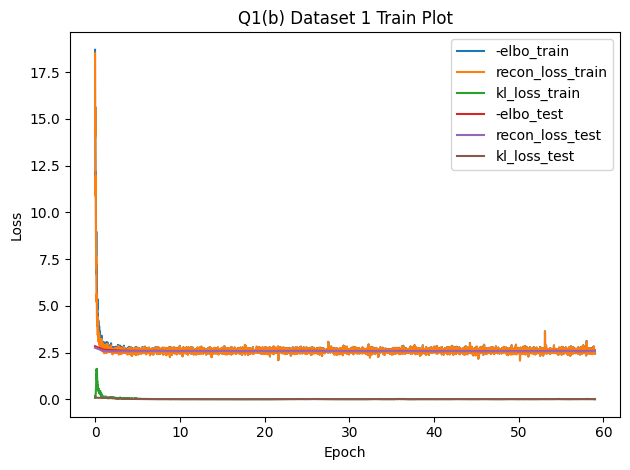

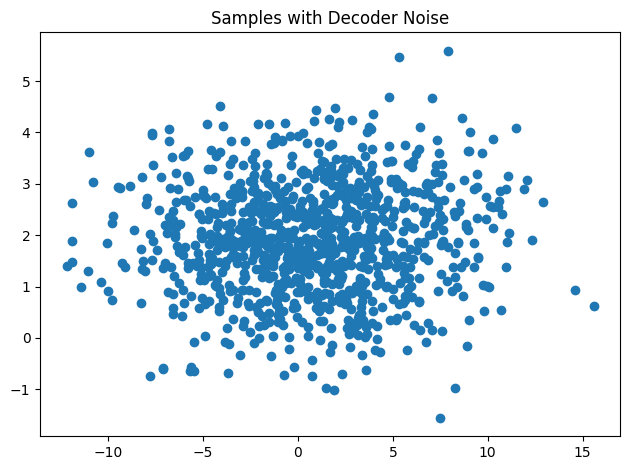

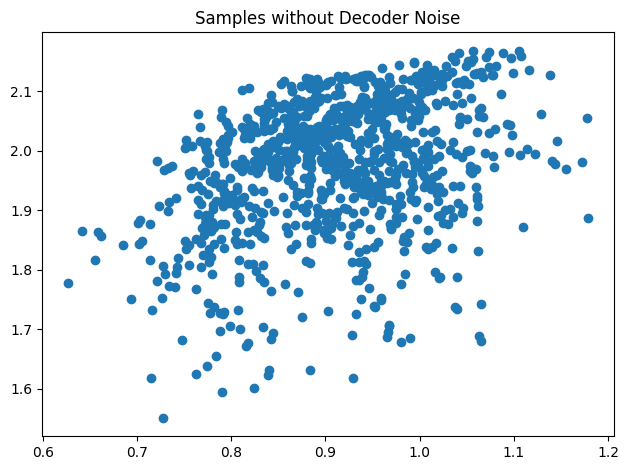

In [27]:
q1_save_results('b', 1, q1)

Epoch 0/60: 100%|██████████| 79/79 [00:00<00:00, 489.55it/s]


Test Loss: 2.7113, Recon Loss: 2.6542, KL Loss: 0.0571


Epoch 1/60: 100%|██████████| 79/79 [00:00<00:00, 496.44it/s]


Test Loss: 2.6264, Recon Loss: 2.5929, KL Loss: 0.0335


Epoch 2/60: 100%|██████████| 79/79 [00:00<00:00, 493.89it/s]


Test Loss: 2.6148, Recon Loss: 2.5868, KL Loss: 0.0281


Epoch 3/60: 100%|██████████| 79/79 [00:00<00:00, 497.03it/s]


Test Loss: 2.5952, Recon Loss: 2.5695, KL Loss: 0.0257


Epoch 4/60: 100%|██████████| 79/79 [00:00<00:00, 495.49it/s]


Test Loss: 2.5852, Recon Loss: 2.5643, KL Loss: 0.0208


Epoch 5/60: 100%|██████████| 79/79 [00:00<00:00, 495.04it/s]


Test Loss: 2.5855, Recon Loss: 2.5701, KL Loss: 0.0153


Epoch 6/60: 100%|██████████| 79/79 [00:00<00:00, 496.84it/s]


Test Loss: 2.5843, Recon Loss: 2.5697, KL Loss: 0.0147


Epoch 7/60: 100%|██████████| 79/79 [00:00<00:00, 497.77it/s]


Test Loss: 2.5921, Recon Loss: 2.5805, KL Loss: 0.0116


Epoch 8/60: 100%|██████████| 79/79 [00:00<00:00, 496.41it/s]


Test Loss: 2.5809, Recon Loss: 2.5699, KL Loss: 0.0109


Epoch 9/60: 100%|██████████| 79/79 [00:00<00:00, 497.70it/s]


Test Loss: 2.5840, Recon Loss: 2.5704, KL Loss: 0.0136


Epoch 10/60: 100%|██████████| 79/79 [00:00<00:00, 499.24it/s]


Test Loss: 2.5887, Recon Loss: 2.5782, KL Loss: 0.0105


Epoch 11/60: 100%|██████████| 79/79 [00:00<00:00, 498.77it/s]


Test Loss: 2.5807, Recon Loss: 2.5673, KL Loss: 0.0135


Epoch 12/60: 100%|██████████| 79/79 [00:00<00:00, 497.85it/s]


Test Loss: 2.5824, Recon Loss: 2.5728, KL Loss: 0.0097


Epoch 13/60: 100%|██████████| 79/79 [00:00<00:00, 498.86it/s]


Test Loss: 2.5807, Recon Loss: 2.5660, KL Loss: 0.0148


Epoch 14/60: 100%|██████████| 79/79 [00:00<00:00, 499.46it/s]


Test Loss: 2.5805, Recon Loss: 2.5677, KL Loss: 0.0128


Epoch 15/60: 100%|██████████| 79/79 [00:00<00:00, 497.81it/s]


Test Loss: 2.5805, Recon Loss: 2.5689, KL Loss: 0.0116


Epoch 16/60: 100%|██████████| 79/79 [00:00<00:00, 500.62it/s]


Test Loss: 2.5885, Recon Loss: 2.5765, KL Loss: 0.0120


Epoch 17/60: 100%|██████████| 79/79 [00:00<00:00, 500.25it/s]


Test Loss: 2.5840, Recon Loss: 2.5740, KL Loss: 0.0100


Epoch 18/60: 100%|██████████| 79/79 [00:00<00:00, 499.42it/s]


Test Loss: 2.5836, Recon Loss: 2.5685, KL Loss: 0.0151


Epoch 19/60: 100%|██████████| 79/79 [00:00<00:00, 488.84it/s]


Test Loss: 2.5871, Recon Loss: 2.5750, KL Loss: 0.0121


Epoch 20/60: 100%|██████████| 79/79 [00:00<00:00, 468.67it/s]


Test Loss: 2.5908, Recon Loss: 2.5752, KL Loss: 0.0156


Epoch 21/60: 100%|██████████| 79/79 [00:00<00:00, 486.47it/s]


Test Loss: 2.5880, Recon Loss: 2.5703, KL Loss: 0.0177


Epoch 22/60: 100%|██████████| 79/79 [00:00<00:00, 492.15it/s]


Test Loss: 2.5866, Recon Loss: 2.5726, KL Loss: 0.0140


Epoch 23/60: 100%|██████████| 79/79 [00:00<00:00, 495.19it/s]


Test Loss: 2.5839, Recon Loss: 2.5708, KL Loss: 0.0131


Epoch 24/60: 100%|██████████| 79/79 [00:00<00:00, 497.62it/s]


Test Loss: 2.5836, Recon Loss: 2.5659, KL Loss: 0.0177


Epoch 25/60: 100%|██████████| 79/79 [00:00<00:00, 497.00it/s]


Test Loss: 2.5816, Recon Loss: 2.5609, KL Loss: 0.0208


Epoch 26/60: 100%|██████████| 79/79 [00:00<00:00, 501.38it/s]


Test Loss: 2.5872, Recon Loss: 2.5668, KL Loss: 0.0204


Epoch 27/60: 100%|██████████| 79/79 [00:00<00:00, 500.22it/s]


Test Loss: 2.5848, Recon Loss: 2.5681, KL Loss: 0.0167


Epoch 28/60: 100%|██████████| 79/79 [00:00<00:00, 501.12it/s]


Test Loss: 2.5857, Recon Loss: 2.5700, KL Loss: 0.0156


Epoch 29/60: 100%|██████████| 79/79 [00:00<00:00, 500.43it/s]


Test Loss: 2.5824, Recon Loss: 2.5666, KL Loss: 0.0158


Epoch 30/60: 100%|██████████| 79/79 [00:00<00:00, 501.44it/s]


Test Loss: 2.5846, Recon Loss: 2.5637, KL Loss: 0.0209


Epoch 31/60: 100%|██████████| 79/79 [00:00<00:00, 497.98it/s]


Test Loss: 2.5892, Recon Loss: 2.5683, KL Loss: 0.0208


Epoch 32/60: 100%|██████████| 79/79 [00:00<00:00, 492.91it/s]


Test Loss: 2.5765, Recon Loss: 2.5552, KL Loss: 0.0213


Epoch 33/60: 100%|██████████| 79/79 [00:00<00:00, 495.51it/s]


Test Loss: 2.5889, Recon Loss: 2.5753, KL Loss: 0.0137


Epoch 34/60: 100%|██████████| 79/79 [00:00<00:00, 494.51it/s]


Test Loss: 2.5842, Recon Loss: 2.5689, KL Loss: 0.0153


Epoch 35/60: 100%|██████████| 79/79 [00:00<00:00, 493.96it/s]


Test Loss: 2.5889, Recon Loss: 2.5752, KL Loss: 0.0137


Epoch 36/60: 100%|██████████| 79/79 [00:00<00:00, 494.54it/s]


Test Loss: 2.5828, Recon Loss: 2.5629, KL Loss: 0.0199


Epoch 37/60: 100%|██████████| 79/79 [00:00<00:00, 494.90it/s]


Test Loss: 2.5830, Recon Loss: 2.5651, KL Loss: 0.0178


Epoch 38/60: 100%|██████████| 79/79 [00:00<00:00, 495.38it/s]


Test Loss: 2.5881, Recon Loss: 2.5767, KL Loss: 0.0113


Epoch 39/60: 100%|██████████| 79/79 [00:00<00:00, 495.35it/s]


Test Loss: 2.5811, Recon Loss: 2.5681, KL Loss: 0.0131


Epoch 40/60: 100%|██████████| 79/79 [00:00<00:00, 494.78it/s]


Test Loss: 2.5791, Recon Loss: 2.5639, KL Loss: 0.0151


Epoch 41/60: 100%|██████████| 79/79 [00:00<00:00, 495.89it/s]


Test Loss: 2.5827, Recon Loss: 2.5720, KL Loss: 0.0106


Epoch 42/60: 100%|██████████| 79/79 [00:00<00:00, 495.71it/s]


Test Loss: 2.5874, Recon Loss: 2.5770, KL Loss: 0.0104


Epoch 43/60: 100%|██████████| 79/79 [00:00<00:00, 494.51it/s]


Test Loss: 2.5834, Recon Loss: 2.5729, KL Loss: 0.0106


Epoch 44/60: 100%|██████████| 79/79 [00:00<00:00, 494.15it/s]


Test Loss: 2.5832, Recon Loss: 2.5737, KL Loss: 0.0095


Epoch 45/60: 100%|██████████| 79/79 [00:00<00:00, 494.65it/s]


Test Loss: 2.5763, Recon Loss: 2.5626, KL Loss: 0.0137


Epoch 46/60: 100%|██████████| 79/79 [00:00<00:00, 496.13it/s]


Test Loss: 2.5782, Recon Loss: 2.5733, KL Loss: 0.0050


Epoch 47/60: 100%|██████████| 79/79 [00:00<00:00, 494.35it/s]


Test Loss: 2.5845, Recon Loss: 2.5820, KL Loss: 0.0025


Epoch 48/60: 100%|██████████| 79/79 [00:00<00:00, 494.06it/s]


Test Loss: 2.5820, Recon Loss: 2.5789, KL Loss: 0.0031


Epoch 49/60: 100%|██████████| 79/79 [00:00<00:00, 494.68it/s]


Test Loss: 2.5858, Recon Loss: 2.5811, KL Loss: 0.0047


Epoch 50/60: 100%|██████████| 79/79 [00:00<00:00, 480.52it/s]


Test Loss: 2.5856, Recon Loss: 2.5802, KL Loss: 0.0054


Epoch 51/60: 100%|██████████| 79/79 [00:00<00:00, 458.19it/s]


Test Loss: 2.5810, Recon Loss: 2.5766, KL Loss: 0.0044


Epoch 52/60: 100%|██████████| 79/79 [00:00<00:00, 480.41it/s]


Test Loss: 2.5815, Recon Loss: 2.5769, KL Loss: 0.0046


Epoch 53/60: 100%|██████████| 79/79 [00:00<00:00, 486.85it/s]


Test Loss: 2.5825, Recon Loss: 2.5793, KL Loss: 0.0033


Epoch 54/60: 100%|██████████| 79/79 [00:00<00:00, 487.08it/s]


Test Loss: 2.5805, Recon Loss: 2.5766, KL Loss: 0.0039


Epoch 55/60: 100%|██████████| 79/79 [00:00<00:00, 489.04it/s]


Test Loss: 2.5866, Recon Loss: 2.5827, KL Loss: 0.0039


Epoch 56/60: 100%|██████████| 79/79 [00:00<00:00, 488.46it/s]


Test Loss: 2.5850, Recon Loss: 2.5804, KL Loss: 0.0045


Epoch 57/60: 100%|██████████| 79/79 [00:00<00:00, 489.86it/s]


Test Loss: 2.5797, Recon Loss: 2.5750, KL Loss: 0.0047


Epoch 58/60: 100%|██████████| 79/79 [00:00<00:00, 489.58it/s]


Test Loss: 2.5772, Recon Loss: 2.5681, KL Loss: 0.0091


Epoch 59/60: 100%|██████████| 79/79 [00:00<00:00, 490.12it/s]


Test Loss: 2.5845, Recon Loss: 2.5798, KL Loss: 0.0047
Final -ELBO: 2.5845, Recon Loss: 2.5798, KL Loss: 0.0047


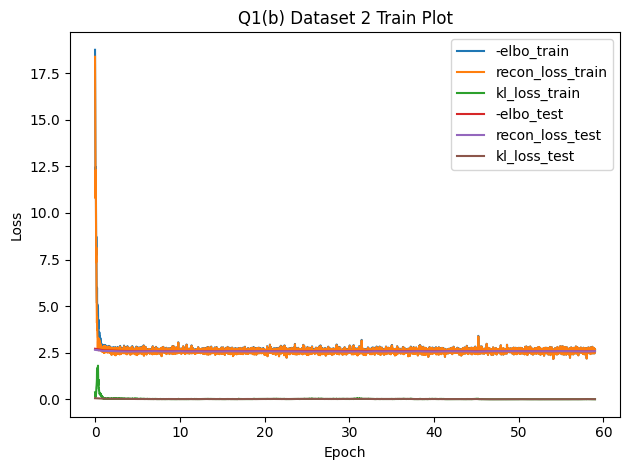

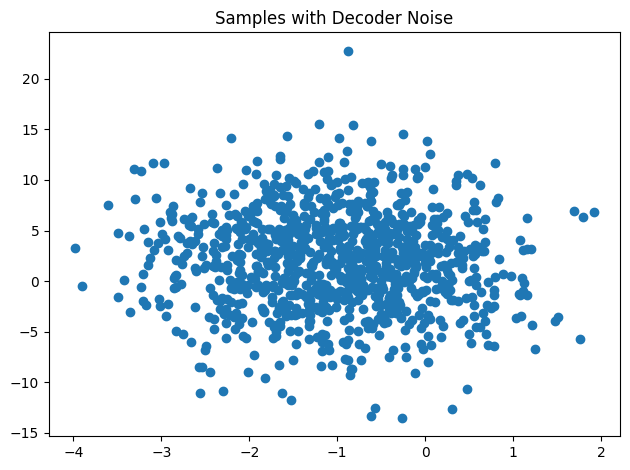

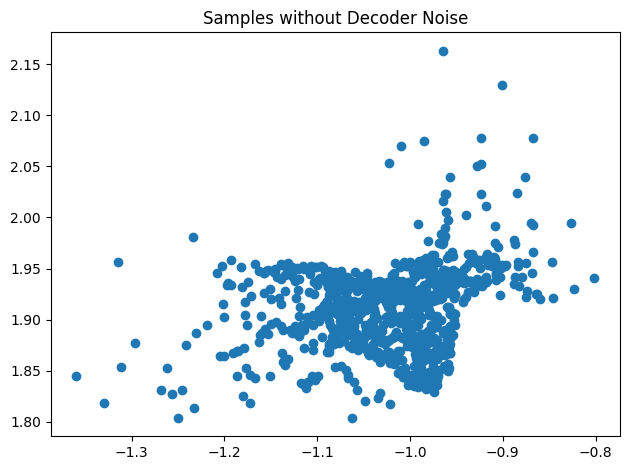

In [28]:
q1_save_results('b', 2, q1)

### Reflection
Compare the sampled xs with and without latents in parts (a) and (b). For which datasets are the latents being used? Why is this happening (i.e. why are the latents being ignored in some cases)? **Write your answer (1-2 sentences) in the given latex template**

# Question 2: VAEs on Images [40pts]
In this question, you will train different VAE models on image datasets. Execute the cell below to visualize the two datasets (colored shapes, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).

In [ ]:
visualize_svhn()
visualize_cifar10()

## Part (a) VAE [20pts]
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can play around with different architectures and try for better results, but the following encoder / decoder architecture below suffices (Note that image input is always $32\times 32$.
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu()
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten() # 16
    linear(4 * 4 * 256, 2 * latent_dim)

Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)



### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
def q2_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    """ YOUR CODE HERE """

### Results
Once you've finished `q2_a`, execute the cells below to visualize and save your results.

In [ ]:
q2_save_results('a', 1, q2_a)

In [ ]:
q2_save_results('a', 2, q2_a)

## Part (b) Hierarchical VAE [20pts]

In this part, we will explore a simplified version of the hierarchical VAE described in [NVAE](https://arxiv.org/pdf/2007.03898.pdf). We will not implement the full NVAE, but rather use some ideas from the paper to explore how to learn a prior distribution p(z).

Implement a hierarchical VAE that follows the following structure.
* $z1$ is a 2x2x12 latent vector where p(z1) is the unit Gaussian.
    * Learn the approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix. I.e., same as a normal VAE, but use a matrix latent rather than a vector. Each dimension is independent.
* $z2$ is a 2x2x12 latent vector.
    * $p_\theta(z2|z1)$ is learned, and implemented as a neural network that parameterizes mean (and log std, optionally).
    * $q_\theta(z2|z1,x)$ is also learned. Implement this as a Residual Normal [see NVAE] over the prior $p_\theta(z2|z1)$.
* The decoder should be a function of $z2$ only.

Some helpful hints:
* Two KL losses should be calculated. The first should match $q_\theta(z|x)$ to the unit Gaussian. The second should match $q_\theta(z2|z1,x)$ and $p_\theta(z2|z1)$, and be taken with respect to $q$.
* When calculating the second KL term, utilize the analytic form for the residual normal. When $q_\theta(z2|z1,x) = N(z2; \mu_\theta(z1) + \Delta \mu_\theta(z1,x), \Sigma_\theta(z1)) * \Delta \Sigma_\theta(z1,x))$, use the following form: `kl_z2 = -z2_residual_logstd - 0.5 + (torch.exp(2 * z2_residual_logstd) + z2_residual_mu ** 2) * 0.5`
* When calculating KL, remember to sum over the dimensions of the latent variable before taking the mean over batch.
* For the prior $p_\theta(z2|z1)$, fix standard deviation to be 1. Learn only the mean. This will help with stability in training.

The following network structures may be useful:
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
        nn.Conv2d(3 + 12, 32, 3, padding=1), # [32, 32, 32]
        LayerNorm(32),
        nn.ReLU(),
        nn.Conv2d(32, 64, 3, stride=2, padding=1), # [64, 16, 16]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 8, 8]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 4, 4]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 2, 2]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 12*2, 3, padding=1), # [12*2, 2, 2]
We assume encoder networks are of the form p(z'|z,x).
When learning q(z1), an x of all zeros can be used as input.
Upscale z with nearest-neighbor projection before concatenating with x.


Decoder
        nn.ConvTranspose2d(12, 64, 3, padding=1), # [64, 2, 2]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 4, 4]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 8, 8]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 16, 16]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), # [32, 32, 32]
        nn.ReLU(),
        nn.Conv2d(32, 3, 3, padding=1), # [3, 32, 32]
```


**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
def q2_b(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    """ YOUR CODE HERE """

### Results
Once you've finished `q2_b`, execute the cells below to visualize and save your results.

In [ ]:
q2_save_results('b', 1, q2_b)

In [ ]:
q2_save_results('b', 2, q2_b)

# Question 3: VQ-VAE [40pts]
In this question, you with train a [VQ-VAE](https://arxiv.org/abs/1711.00937) on the colored shapes dataset and SVHN. If you are confused on how the VQ-VAE works, you may find [Lilian Weng's blogpost](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vq-vae-and-vq-vae-2) to be useful.

You may experiment with different hyperparameters and architecture designs, but the following designs for the VQ-VAE architecture may be useful.

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)
batch_norm2d(dim)

residual_block(dim)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 3, 1, 1)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 1, 1, 0)

Encoder
    conv2d(3, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    conv2d(256, 256, 4, 2, 1) 8 x 8
    residual_block(256)
    residual_block(256)

Decoder
    residual_block(256)
    residual_block(256)
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 3, 4, 2, 1) 32 x 32
```

A few other tips:
*   Use a codebook with $K = 128$ latents each with a $D = 256$ dimensional embedding vector
*   You should initialize each element in your $K\times D$ codebook to be uniformly random in $[-1/K, 1/K]$
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer
*   Center and scale your images to $[-1, 1]$
*   Supposing that $z_e(x)$ is the encoder output, and $z_q(x)$ is the quantized output using the codebook, you can implement the straight-through estimator as follows (where below is fed into the decoder):
  * `(z_q(x) - z_e(x)).detach() + z_e(x)` in Pytorch
  * `tf.stop_gradient(z_q(x) - z_e(x)) + z_e(x)` in Tensorflow.

In addition to training the VQ-VAE, you will also need to train a Transformer prior on the categorical latents in order to sample. Feel free to use your implementation for HW1! You should flatten the VQ-VAE tokens into a [H x W] sequence, and use a start token.

**You will provide the following deliverables**


1.   Over the course of training, record the average loss of the training data (per minibatch) and test data (for your entire test set) **for both your VQ-VAE and Transformer prior**. Code is provided that automatically plots the training curves.
2. Report the final test set performances of your final models
3. 100 samples from your trained VQ-VAE and Transformer prior
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)

## Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
def q3(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE test losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of Transformer prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of Transformer prior test losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """

    """ YOUR CODE HERE """

## Results
Once you've finished `q3`, execute the cells below to visualize and save your results.

In [ ]:
q3_save_results(1, q3)

In [ ]:
q3_save_results(2, q3)

# File Saving Utility


In [ ]:
# one way to save files
from google.colab import files
import os
import os.path as osp
for fname in os.listdir('results'):
    files.download('results/' + fname)